# AstraDB ColBERT or Pinecone/Weaviate Hybrid Search?
Author: Tiernan Lindauer, Datastax Inc.

## Step 1: Setup

Install the required packages (`requirements.txt`)

In [2]:
# Some minor setup for the notebook
import warnings
import nest_asyncio

# Ignore all warnings
warnings.filterwarnings("ignore")

# Allows for running async code in Jupyter notebooks
nest_asyncio.apply()

In [3]:
import os
import time
import openai
import weaviate
from dotenv import load_dotenv
from langchain_community.retrievers import (
    WeaviateHybridSearchRetriever,
)
from datasets import load_dataset
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

### Use the HuggingFace RAG mini benchmark

In [5]:
bioasq = load_dataset("rag-datasets/rag-mini-bioasq", "question-answer-passages")['test']
corpus = load_dataset("rag-datasets/rag-mini-bioasq", "text-corpus")['passages']

ValueError: Invalid pattern: '**' can only be an entire path component

In [163]:
import ast
new_bioasq = []
for row in bioasq:
    new_bioasq.append({
        'question': row['question'],
        'relevant_passage_ids': ast.literal_eval(row['relevant_passage_ids'])
    })
bioasq = new_bioasq

In [144]:
# Specify the number of results for each search.
n_results = 9

Create Weaviate cluster (using authentication) -- **you need to create this, then come back**!

In [114]:
WEAVIATE_URL = input("Enter your weaviate cluster URL: ")

In [115]:
WEAVIATE_API_KEY = input("Enter your weaviate API key: ")

In [11]:
OPENAI_API_KEY = input("Enter your OpenAI API key: ")

In [116]:
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY
auth_config = weaviate.AuthApiKey(api_key=WEAVIATE_API_KEY)
client = weaviate.Client(
    url=WEAVIATE_URL,
    auth_client_secret=auth_config,
    additional_headers={
        "X-Openai-Api-Key": OPENAI_API_KEY,
    },
)
embeddings = OpenAIEmbeddings()

In [145]:
weaviate_retriever = WeaviateHybridSearchRetriever(
    client=client,
    index_name="LangChain",
    text_key="text",
    attributes=['index'],
    create_schema_if_missing=True,
    k=n_results,
)

In [122]:
# ONLY RUN ONCE!
import time
from tqdm import tqdm

corpus_docs = []
str_time = time.strftime("%m/%d/%Y")
for doc in tqdm(corpus):
    corpus_docs.append(Document(
        metadata={
            "name": "rag-mini-bioasq",
            "date": str_time,
            "index": doc['id'],
        },
        page_content=doc['passage']
    ))
weaviate_retriever.add_documents(corpus_docs)
# Now let's load Pinecone

100%|██████████| 40221/40221 [00:00<00:00, 88844.41it/s]


In [73]:
import certifi
from pinecone_text.sparse import BM25Encoder

os.environ['SSL_CERT_FILE'] = certifi.where()

bm25_encoder = BM25Encoder().default()

In [74]:
bm25_encoder.fit(corpus)
current_directory = os.getcwd()
json_file_path = os.path.join(current_directory, "bm25_values.json")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [75]:
from pinecone import Pinecone, ServerlessSpec

pc_api_key = input("Enter your Pinecone API key: ")
# initialize Pinecone client
pc = Pinecone(api_key=pc_api_key)

In [105]:
index_name = "rag-mini-bioasq"

In [127]:
# create the index
texts = []
metadatas = []
if index_name not in pc.list_indexes().names():
    str_time = time.strftime("%m/%d/%Y")
    pc.create_index(
        name=index_name,
        dimension=1536,  # dimensionality of dense model
        metric="dotproduct",  # sparse values supported only for dotproduct
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

    for doc in corpus:
        texts.append(doc['passage'])
        metadatas.append({
            "name": "rag-mini-bioasq",
            "date": str_time,
            "index": doc['id'],
        })

In [107]:
index = pc.Index(index_name)

In [146]:
from langchain_community.retrievers import PineconeHybridSearchRetriever

pinecone_retriever = PineconeHybridSearchRetriever(
    embeddings=embeddings, sparse_encoder=bm25_encoder, index=index, top_k=n_results
)

In [109]:
if len(texts) > 0 and len(metadatas) > 0:
    pinecone_retriever.add_texts(texts, metadatas=metadatas)

  0%|          | 0/1257 [00:00<?, ?it/s]

KeyboardInterrupt: 

Pure BM25 implementation setup:

In [119]:
from langchain_community.retrievers import BM25Retriever

In [147]:
bm25_retriever = BM25Retriever.from_documents(corpus_docs)
bm25_retriever.k = n_results

Let's run an example query to compare the results of Weaviate/Pinecone to the perfect K-Nearest-Neighbors (KNN) search later.

In [149]:
question = bioasq[0]['question']

In [150]:
print("Weaviate results:")
weaviate_results = weaviate_retriever.invoke(question, score=True)
weaviate_indices = [result.metadata['index'] for result in weaviate_results]
print("    Metadata: ", weaviate_indices)
print("Pinecone results:")
pinecone_results = pinecone_retriever.invoke(question, score=True)
pinecone_indices = [int(result.metadata['index']) for result in pinecone_results]
print("    Metadata: ", pinecone_indices)
print("BM25 results:")
bm25_results = bm25_retriever.invoke(question, score=True)
bm25_indices = [result.metadata['index'] for result in bm25_results]
print("    Indices: ", bm25_indices)
print("Truth:")
print("    Indices: ", bioasq[0]['relevant_passage_ids'])

Weaviate results:
    Metadata:  [15617541, 23001136, 22584707, 11484199, 16080919, 17965226, 9727738, 12239580, 2309705]
Pinecone results:
    Metadata:  [15617541, 11484199, 16080919, 16986122, 17965226, 9727738, 12878302, 17108762, 10792313]
BM25 results:
    Indices:  [22584707, 23523603, 11484199, 20009762, 17108762, 9727738, 2309705, 22574178, 25960806]
Truth:
    Indices:  [20598273, 6650562, 15829955, 15617541, 23001136, 8896569, 21995290, 12239580, 15858239]


## Step 2: K-Nearest-Neighbors (KNN) Search 

In [125]:
from sklearn.neighbors import NearestNeighbors

In [128]:
def embed_texts(texts):
    return embeddings.embed_documents(texts)


corpus_embeddings = embed_texts([doc['passage'] for doc in corpus])

# Use KNN to find the closest 5 documents
knn = NearestNeighbors(n_neighbors=n_results, metric='cosine').fit(corpus_embeddings)

In [94]:
distances, knn_indices = knn.kneighbors([embeddings.embed_query(question)])
knn_indices = knn_indices[0]
print("KNN results:")
print("    Indices: ", knn_indices)

KNN results:
    Indices:  [4895 9768 5290 4091 9417 4210  659 4026 3164 1836]


In [195]:
import numpy as np
from scipy.stats import kendalltau


def dcg(relevances, k):
    relevances = np.array(relevances)[:k]
    if relevances.size:
        return np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    return 0.0


def ndcg(relevances, k):
    ideal_relevances = sorted(relevances, reverse=True)
    return dcg(relevances, k) / dcg(ideal_relevances, k) if dcg(ideal_relevances, k) > 0 else 0.0


def calculate_kendall_tau(ground_truth, algorithm_result):
    assert len(ground_truth) == len(algorithm_result), "The input lists must have the same length"

    total_tau = 0
    num_lists = len(ground_truth)

    for gt_list, alg_list in zip(ground_truth, algorithm_result):
        tau, _ = kendalltau(gt_list, alg_list)
        total_tau += tau

    average_tau = total_tau / num_lists
    return average_tau


def get_result_stats(retrieved_docs, ground_truth, k=n_results):
    # deep copy the lists
    retrieved_docs = [retrieved_doc.copy() for retrieved_doc in retrieved_docs]
    ground_truth = [relevant.copy() for relevant in ground_truth]
    
    precisions = []
    recalls = []
    f1_scores = []
    
    # make ground truth, retrieved docs have same length of each sublist
    new_retrieved_docs = []
    for retrieved in retrieved_docs:
        new_retrieved_docs.append(retrieved[:len(ground_truth[0])])
    retrieved_docs = new_retrieved_docs
    
    new_ground_truth = []
    for relevant in ground_truth:
        new_ground_truth.append(relevant[:len(retrieved_docs[0])])
    ground_truth = new_ground_truth

    for retrieved, relevant in zip(retrieved_docs, ground_truth):
        min_len = min(len(retrieved), len(relevant))
        retrieved = retrieved[:min_len]
        relevant = relevant[:min_len]
        
        true_positives = len(set(retrieved).intersection(set(relevant)))
        
        precision = true_positives / len(retrieved)
        recall = true_positives / len(relevant)
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)

    mrr = []
    ndcg_scores = []

    for retrieved, relevant in zip(retrieved_docs, ground_truth):
        # Create relevance scores
        relevances = [1 if doc in relevant else 0 for doc in retrieved]

        # Calculate MRR
        reciprocal_rank = 0
        for i, rel in enumerate(relevances):
            if rel == 1:
                reciprocal_rank = 1 / (i + 1)
                break
        mrr.append(reciprocal_rank)

        # Calculate nDCG
        ndcg_score = ndcg(relevances, k)
        ndcg_scores.append(ndcg_score)

    avg_mrr = np.mean(mrr)
    avg_ndcg = np.mean(ndcg_scores)

    avg_kendall_tau = calculate_kendall_tau(ground_truth, retrieved_docs)

    return {
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1-Score': avg_f1,
        'MRR': avg_mrr,
        'nDCG': avg_ndcg,
        'Kendall-Tau': avg_kendall_tau
    }

Evaluate the results of the example query above.

In [193]:
print("Weaviate results:", get_result_stats([weaviate_indices], [bioasq[0]['relevant_passage_ids']], ))
print("Pinecone results: ", get_result_stats([pinecone_indices], [bioasq[0]['relevant_passage_ids']], ))
print("BM25 results: ", get_result_stats([bm25_indices], [bioasq[0]['relevant_passage_ids']], ))

Weaviate results: {'Precision': 0.3333333333333333, 'Recall': 0.3333333333333333, 'F1-Score': 0.3333333333333333, 'MRR': 1.0, 'nDCG': 0.9134015924715543, 'Kendall-Tau': -0.3333333333333333}
Pinecone results:  {'Precision': 0.1111111111111111, 'Recall': 0.1111111111111111, 'F1-Score': 0.1111111111111111, 'MRR': 1.0, 'nDCG': 1.0, 'Kendall-Tau': 0.16666666666666666}
BM25 results:  {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'MRR': 0.0, 'nDCG': 0.0, 'Kendall-Tau': -0.16666666666666666}


## Step 3: Setup ColBERT through AstraDB

In [28]:
import time
from langchain.text_splitter import RecursiveCharacterTextSplitter
from ragstack_colbert import CassandraDatabase, ColbertEmbeddingModel, ColbertVectorStore, ColbertRetriever
import logging
logging.getLogger('cassandra').setLevel(logging.ERROR)  # workaround to suppress logs

/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:284: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)


In [29]:
astra_database_id = input("Enter your AstraDB database ID: ")

In [30]:
astra_token = input("Enter your AstraDB token: ")

In [131]:
keyspace = "benchmarking3"
database = CassandraDatabase.from_astra(astra_token=astra_token, database_id=astra_database_id, keyspace=keyspace)
embedding_model = ColbertEmbeddingModel()
vector_store = ColbertVectorStore(database=database, embedding_model=embedding_model)

In [99]:
def store_in_astra(chunks):
    metadatas = []
    for i in range(len(chunks)):
        metadatas.append({"name": index_name, "date": time.strftime("%m/%d/%Y"), 'index': i})
    vector_store.add_texts(texts=chunks, metadatas=metadatas, doc_id="benchmarking")


store_in_astra(corpus)

KeyboardInterrupt: 

In [132]:
colbert_retriever = ColbertRetriever(embedding_model=embedding_model, database=database)

In [186]:
print("ColBERT results:")
print(colbert_retriever.text_search(question, k=n_results))

ColBERT results:
[(Chunk(doc_id='rag-bio-test', chunk_id=24, text='Previous studies have shown that cultured fibroblasts derived from patients with \ngenetic defects in lysosomal acid lipase (i. e. the Wolman Syndrome and \nCholesteryl Ester Storage Disease) are defective in their ability to hydrolyze \nthe cholesteryl esters contained in plasma low density lipoprotein (LDL). As a \nresult, these mutant cells show a reduced responsiveness to the regulatory \nactions of LDL, as evidenced by a decreased LDL-mediated suppression of the \nactivity of 3-hydroxy-3-methylglutaryl coenzyme A reductase and by a decreased \nLDL-mediated activation of cellular cholesteryl ester formation. In the current \nstudies, the Wolman Syndrome and Cholesteryl Ester Storage Disease cells were \ngrown in the same Petri dish with mutant fibroblasts derived from a patient with \nthe homozygous form of Familial Hypercholesterolemia. Whereas pure monolayers of \neither the Familial Hypercholesterolemia cells (la

In [134]:
from tqdm import tqdm
from time import time

In [138]:
all_knn_indices = []
all_weaviate_indices = []
all_pinecone_indices = []
all_colbert_indices = []
all_bm25_indices = []

weaviate_latencies = []
pinecone_latencies = []
colbert_latencies = []
bm25_latencies = []

def run_line(line):
    line = line.strip()

    start = time()
    weaviate_results = weaviate_retriever.invoke(line)
    end = time()
    weaviate_latencies.append(end - start)
    weaviate_indices = [result.metadata['index'] for result in weaviate_results]
    all_weaviate_indices.append(weaviate_indices)

    start = time()
    pinecone_results = pinecone_retriever.invoke(line)
    end = time()
    pinecone_latencies.append(end - start)
    pinecone_indices = [int(result.metadata['index']) for result in pinecone_results]
    all_pinecone_indices.append(pinecone_indices)

    start = time()
    colbert_results = colbert_retriever.text_search(line, k=n_results)
    end = time()
    colbert_indices = [int(float(result[0].metadata['index'])) for result in colbert_results]
    colbert_latencies.append(end - start)
    all_colbert_indices.append(colbert_indices)

    start = time()
    bm25_results = bm25_retriever.invoke(line)
    end = time()
    bm25_indices = [result.metadata['index'] for result in bm25_results]
    bm25_latencies.append(end - start)
    all_bm25_indices.append(bm25_indices)

    distances, knn_indices = knn.kneighbors([embeddings.embed_query(line)])
    knn_indices = knn_indices[0]
    all_knn_indices.append(knn_indices)
    
for question in tqdm([doc['question'] for doc in bioasq][:400]):
    run_line(question)


100%|██████████| 400/400 [14:58<00:00,  2.25s/it]


In [142]:
for question in tqdm([doc['question'] for doc in bioasq][1000:2000]):
    run_line(question)

100%|██████████| 600/600 [22:24<00:00,  2.24s/it]


In [181]:
print(all_weaviate_indices[1])
true_indices = [row['relevant_passage_ids'][:9] for row in bioasq[:len(all_weaviate_indices)]]

[23382875, 34667080, 21514161, 29680500, 23888072, 25052069, 22436374, 16159418, 18520300, 19048033]


In [196]:
weaviate_stats = get_result_stats(all_weaviate_indices, true_indices, n_results)
pinecone_stats = get_result_stats(all_pinecone_indices, true_indices, n_results)
colbert_stats = get_result_stats(all_colbert_indices, true_indices, n_results)
bm25_stats = get_result_stats(all_bm25_indices, true_indices, n_results)

In [197]:
from rich.text import Text
import rich
from rich.console import Console

console = Console()

# Print a table of the results (Weaviate, Pinecone, ColBERT vs the different stats)
table = rich.table.Table(title="Retrieval Results @k={}".format(n_results), show_edge=False)
table.add_column("Metric", style="cyan")
table.add_column("Weaviate", style="magenta")
table.add_column("Pinecone", style="green")
table.add_column("AstraDB + ColBERT", style="blue")
table.add_column("BM25", style="yellow")


def format_cell(value, is_max=True):
    text = Text(str(value))
    if is_max:
        text.stylize("bold underline")
    return text


# Add stats to table with formatting
for metric in weaviate_stats:
    values = [
        weaviate_stats[metric],
        pinecone_stats[metric],
        colbert_stats[metric],
        bm25_stats[metric],
    ]
    max_value = max(values)
    formatted_values = [
        format_cell(value, is_max=(value == max_value)) for value in values
    ]
    table.add_row(metric, *formatted_values)

# Calculate average latencies and add them to the table
avg_weaviate_latency = sum(weaviate_latencies) / len(weaviate_latencies)
avg_pinecone_latency = sum(pinecone_latencies) / len(pinecone_latencies)
avg_colbert_latency = sum(colbert_latencies) / len(colbert_latencies)
avg_bm25_latency = sum(bm25_latencies) / len(bm25_latencies)

latencies = [avg_weaviate_latency, avg_pinecone_latency, avg_colbert_latency, avg_bm25_latency]
min_latency = min(latencies)
formatted_latencies = [
    format_cell(latency, is_max=(latency == min_latency)) for latency in latencies
]

table.add_row("Average Latency", *formatted_latencies)

# Print the table
console.print(table)

                                          Retrieval Results @k=9                                           
 Metric          ┃ Weaviate            ┃ Pinecone            ┃ AstraDB + ColBERT     ┃ BM25                
━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━
 Precision       │ 0.39964880952380955 │ 0.17422777777777776 │ 0.0003333333333333333 │ 0.24708174603174604 
 Recall          │ 0.39964880952380955 │ 0.17422777777777776 │ 0.0003333333333333333 │ 0.24708174603174604 
 F1-Score        │ 0.39964880952380955 │ 0.17422777777777776 │ 0.0003333333333333333 │ 0.24708174603174604 
 MRR             │ 0.6843492063492063  │ 0.43645158730158734 │ 0.003125              │ 0.5016138888888889  
 nDCG            │ 0.7264795246342591  │ 0.4639743363682928  │ 0.003315464876785729  │ 0.5332439198223763  
 Average Latency │ 0.5623953902721405  │ 0.21147561430931092 │ 1.1388931260108948    │ 0.09238642311096192 

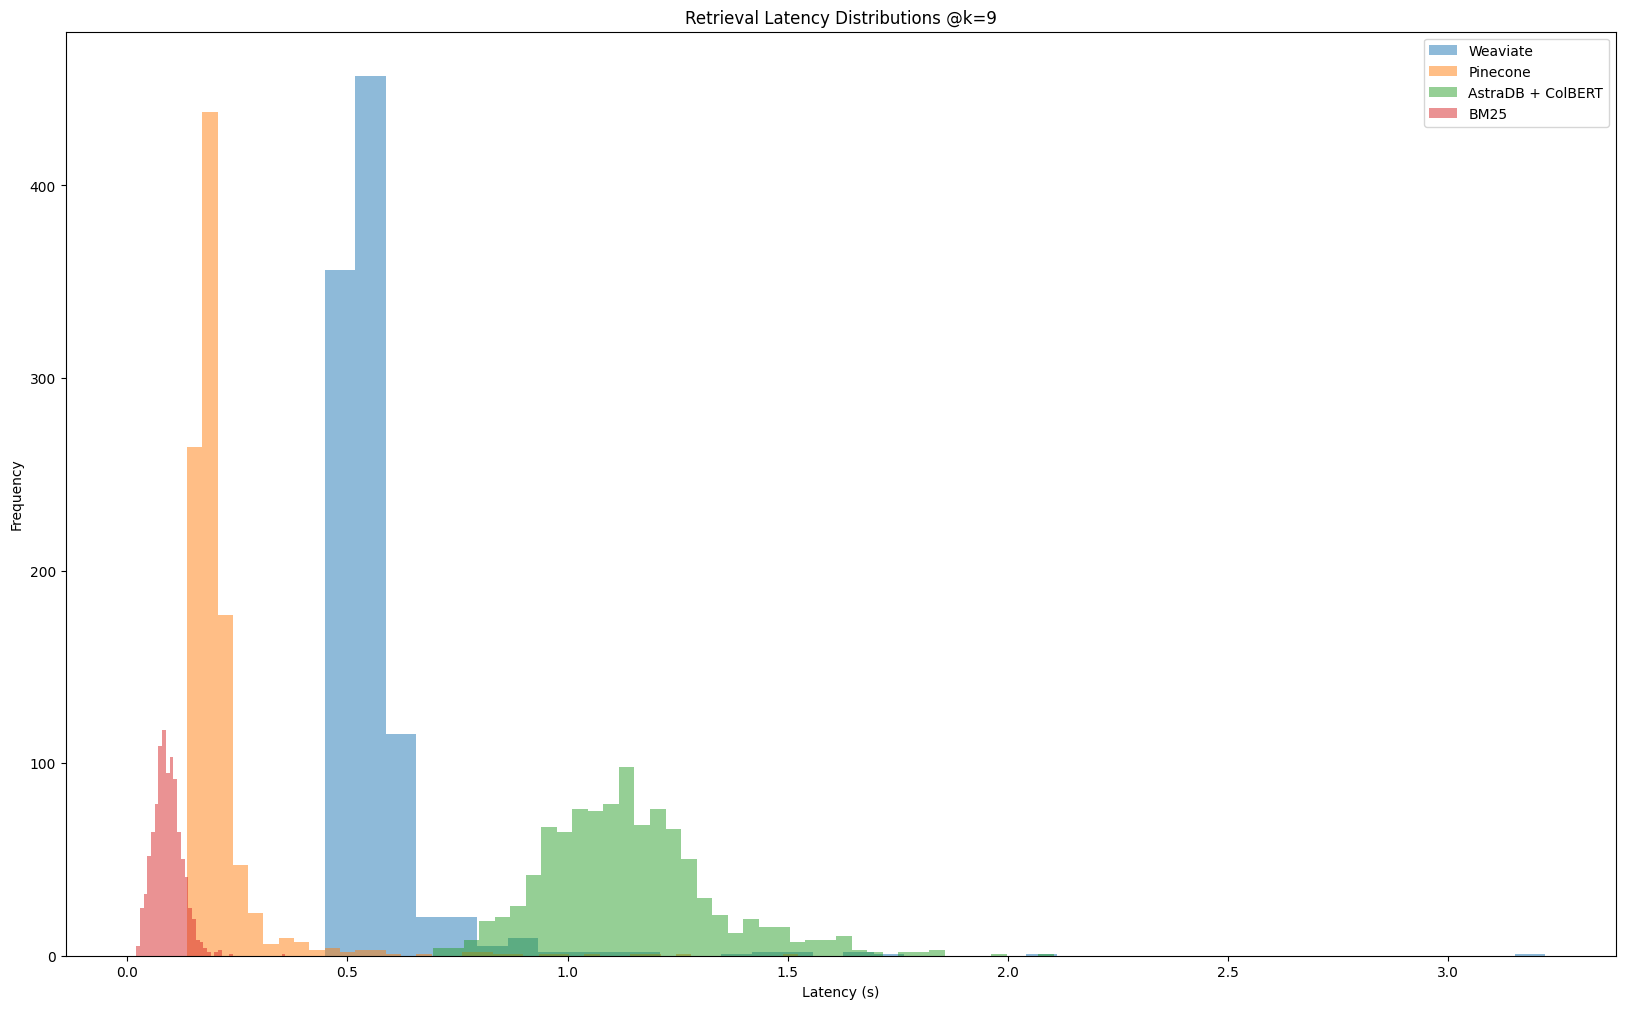

In [198]:
# Plot latency distributions
import matplotlib.pyplot as plt

bins = 40
plt.hist(weaviate_latencies, bins=bins, alpha=0.5, label='Weaviate')
plt.hist(pinecone_latencies, bins=bins, alpha=0.5, label='Pinecone')
plt.hist(colbert_latencies, bins=bins, alpha=0.5, label='AstraDB + ColBERT')
plt.hist(bm25_latencies, bins=bins, alpha=0.5, label='BM25')

plt.legend(loc='upper right')
plt.xlabel('Latency (s)')
plt.ylabel('Frequency')
plt.title('Retrieval Latency Distributions @k={}'.format(n_results))

# set the size bigger
plt.rcParams["figure.figsize"] = (20, 12)